# Proyek Analisis Data: [Input Nama Dataset]
- **Nama:** Muhammad Hilmi Al FArisi
- **Email:** b25b9d032@student.devacademy.id / faris.workidea@gmail.com
- **ID Dicoding:** B25B9D032

## Menentukan Pertanyaan Bisnis

Pada submission ini, data yang digunakan adalah dasaet E-Commerce Public yang berisi berbagai data demografis pelanggan, penjual, produk, dan pemeasanan yang dapat dieksplore untuk menemukan insight bisnis. Pada proses analisis data ini bertujuan untuk menemukan insight dan jawaban dari pertanyaan bisnis yang saya tentukan sebagai berikut :

- Kategori produk apa saja yang mendapatkan nilai rating 5 terbanyak?
- Seberapa besar faktor volume dan berat barang mempengaruhi harga pengiriman barang?
- Di mana letak geografis yang mempunyai angka pembelian tertinggi dan terendah? (Geospatial Analysis)
- Siapa sajakan pelanggan yang mempunyai performance paling tinggi dari sisi recency pembelian, frekuensi pembelian, dan total biaya belanja yang dikeluarkan? (RFM Analysis)


## Import Semua Packages/Library yang Digunakan

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point


## Data Wrangling

### Gathering Data

In [4]:
customer_df = pd.read_csv('./Data/customers_dataset.csv')
order_df = pd.read_csv('./Data/orders_dataset.csv')
order_payment_df = pd.read_csv('./Data/order_payments_dataset.csv')
order_review_df = pd.read_csv('./Data/order_reviews_dataset.csv')
product_df = pd.read_csv('./Data/products_dataset.csv')
geolocation_df = pd.read_csv('./Data/geolocation_dataset.csv')
order_item_df = pd.read_csv('./Data/order_items_dataset.csv')


**Insight:**
- Data Order mempunyai beberapa dataset setipe di antaranya order_item, order_review, dan order payment yang bisa dimerge untuk mendapatkan informasi lengkap terkait pemesanan;
- Data order yang lengkap mempunyai beberapa foreign key diantaranya column product_id untuk data product, column seller_id untuk data seller, column customer_id untuk data customer;
- Data customer mempunyai foreign key dengan data geolocation yaitu column geolocation_zip_code_prefix untuk mendapatkan data lokasi tiap customer;
- Terdapat 99440 data pemesanan sejak September 2016 hingga Oktober 2018;
- Data yang ada cukup representatif untuk dianalisis demi menjawab pertanyaan-pertanyaan di atas.


### Assessing Data

In [5]:
# Mencari missing value dan tipe data yang tidak sesuai yang berpotensi mengurangi kualitas analisis data
order_df.info()
order_payment_df.info()
order_review_df.info()
customer_df.info()
product_df.info()
geolocation_df.info()
order_item_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  obje

In [6]:
# Menemukan data duplikat yang berpotensi mengurangi kualitas analisis data
order_df.duplicated().sum()
order_payment_df.duplicated().sum()
order_review_df.duplicated().sum()
customer_df.duplicated().sum()
product_df.duplicated().sum()
geolocation_df.duplicated().sum()
order_item_df.duplicated().sum()

np.int64(0)

In [7]:
# Mencari Outliers / Inaccurate value yang berpotensi mengurangi kualitas data
order_df.describe()
order_payment_df.describe()
order_review_df.describe()
customer_df.describe()
product_df.describe()
geolocation_df.describe()
order_item_df.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


**Insight:**
1. Temuan Missing Value
- Terdapat missing value pada order_approved_at, order_delivered_carrier_date, dan order_delivered_customer_date pada data order. Namun ketiga kolom tersebut tidak berhubungan dengan pertanyaan bisinis yang akan diexplore.
- Terdapat missing value pada review_comment_title dan review_comment_massage pada data order_review. Namun ketiga kolom tersebut tidak berhubungan dengan pertanyaan bisinis yang akan diexplore.
- Terdapat missing value pada product_cat_name, length, description_length, photos, dan berbagai ukuran produk pada data order_item. Beberapa kolom yang berkaitan dengan ukuran dan berat produk berkaitan dengan kualitas hasil analisis ini.

2. Temuan kesalahan tipe data
- Seluruh tipe data pada semua kolom sudah sesuai kecuali pada order_approved_at, order_delivered_carrier_date, dan order_delivered_customer_date pada data order yang seharusnya datettime namun aktualnya object. Namun ketiga kolom tersebut tidak berhubungan dengan pertanyaan bisinis yang akan diexplore.

3. Temuan data duplikat
- Dapat duplikat terdeteksi hanya pada data geolocation, namun hal tersebut wajar karena perbedaan hanya minor terdapat pada koordinat longitude dan latitude yang sebenarnya memang menjadi kolom pembeda pada pertanyaan analisis kita.

4. Tidak ditemukan adanya *outliers/inaccurate value* pada data-data di atas
5. Ditemukan data invalid dalam kolom longitude dan latitude pada data geolocation yang berada di luar wilayah negara Brazil

### Cleaning Data

In [8]:
# Karena missing value kolom-kolom yang berkaitan dengan ukuran dan berat produk seperti weight, length, height, dan width hanya 0,01%, maka saya akan ganti dengan mean agar tidak merusak nilai distribusi

product_df.fillna({
    'product_weight_g': product_df['product_weight_g'].mean(),
    'product_length_cm': product_df['product_length_cm'].mean(),
    'product_height_cm': product_df['product_height_cm'].mean(),
    'product_width_cm': product_df['product_width_cm'].mean()
}, inplace=True)

In [9]:
# Karena missing value kolom-kolom tanggal pada data order seperti order_approved_at, order_delivered_carrier_date, dan order_delivered_customer_date, tidak akan terpakai, maka kolom-kolom tersebut akan saya drop
for col in ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']:
  order_df.drop(col, axis=1, inplace=True)


In [10]:
# Karena missing value pada data order_review juga tidak terpakai, maka saya akan drop kolom-kolom tersebut
for col in ['review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']:
  order_review_df.drop(col, axis=1, inplace=True)

In [11]:
# Memfilter koordinat yang hanya berada dalam batas koordinat wilayah negara brazil
geolocation_df = geolocation_df[
    (geolocation_df['geolocation_lat'].between(-35, 5)) &
    (geolocation_df['geolocation_lng'].between(-74, -34))
]

**Insight:**
- Missing value terkait ukuran dan berat produk diisi dengan nilai mean karena jumlah tidak signifikan dan tidak akan merubah distribusi data
- Beberapa kolom tanggal pada data order kecuali order_purchase_timestamp dan beberapa kolom pada data order_review dihilangkan agar dataset lebih rapih dan clean
- Beberapa data geolocation dengan anga koordinat longitude dan latitude di luar wilayah negara brazil dihilangkan

## Exploratory Data Analysis (EDA)

### Explore data Product Review

In [12]:
product_orderItem_df = pd.merge(
    left=product_df,
    right=order_item_df,
    how='left',
    left_on='product_id',
    right_on='product_id'
)

product_review_df = pd.merge(
    left=product_orderItem_df,
    right=order_review_df,
    how='left',
    left_on='order_id',
    right_on='order_id'
)
# Melihat product dengan review bintang 5 terbanyak
product_with_R5_df = product_review_df[product_review_df['review_score'] == 5]
topProduct_with_R5_df = product_with_R5_df.groupby(['product_category_name']).size().reset_index(name='count_5stars').sort_values('count_5stars', ascending=False)
topProduct_with_R5_df.head(10)

,product_category_name,count_5stars
11,beleza_saude,5858
13,cama_mesa_banho,5785
32,esporte_lazer,5121
54,moveis_decoracao,4452
44,informatica_acessorios,4200
71,utilidades_domesticas,3985
66,relogios_presentes,3331
12,brinquedos,2517
40,ferramentas_jardim,2478
8,automotivo,2381


### Explore data potensial variabel yang berkorelasi dengan harga pengiriman barang

In [13]:
order_wtItem = pd.merge(
    left=order_df,
    right=order_item_df,
    how='left',
    left_on='order_id',
    right_on='order_id'
)

freightFactor_df = pd.merge(
    left=order_wtItem,
    right=product_df,
    how='left',
    left_on='product_id',
    right_on='product_id'
)

# Membuat kolom volume (len*width*height)
freightFactor_df['volume'] = freightFactor_df['product_length_cm'] * freightFactor_df['product_width_cm'] * freightFactor_df['product_height_cm']
freightValue_factor_df = freightFactor_df.drop(columns=['order_status', 'order_purchase_timestamp', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'shipping_limit_date', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_category_name', 'seller_id'], axis=1)
freightValue_factor_df.head()

,order_id,customer_id,order_item_id,product_id,price,freight_value,product_weight_g,volume
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,1.0,87285b34884572647811a353c7ac498a,29.99,8.72,500.0,1976.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,1.0,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76,400.0,4693.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,1.0,aa4383b373c6aca5d8797843e5594415,159.90,19.22,420.0,9576.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,27.20,450.0,6000.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,1.0,65266b2da20d04dbe00c5c2d3bb7859e,19.90,8.72,250.0,11475.0


In [14]:
freightFactor_df['freight_value'].corr(freightFactor_df['volume'])

np.float64(0.5872681017261773)

In [15]:
freightFactor_df['freight_value'].corr(freightFactor_df['product_weight_g'])

np.float64(0.6104100183276739)

### Explorasi data lokasi pelanggan dengan pembelian tertinggi (Geospatial Analysis)

In [16]:
# Membuat dataframe angka pembelian tiap lokasi geografis
order_Withpayment = pd.merge(
    left=order_df,
    right=order_payment_df,
    how='left',
    left_on='order_id',
    right_on='order_id'
)

customer_order_Withpayment = pd.merge(
    left=customer_df,
    right=order_Withpayment,
    how='left',
    left_on='customer_id',
    right_on='customer_id'
)

customer_geolocation_df = pd.merge(
    left=customer_order_Withpayment,
    right=geolocation_df,
    how='left',
    left_on='customer_zip_code_prefix',
    right_on='geolocation_zip_code_prefix'
)

geoloc_payment_df = customer_geolocation_df.groupby(['customer_zip_code_prefix'], as_index=False).agg({
    'geolocation_lat' : 'mean',
    'geolocation_lng' : 'mean',
    'payment_value' : 'sum',
    'geolocation_city' : 'first',
    'geolocation_state' : 'first'
})

geoloc_payment_df.sort_values(by='payment_value', ascending=False).head(10)

,customer_zip_code_prefix,geolocation_lat,geolocation_lng,payment_value,geolocation_city,geolocation_state
6027,24220,-22.903245,-43.107024,24612206.52,niteroi,RJ
6028,24230,-22.878637,-43.086096,21932984.78,niterói,RJ
5885,22790,-23.012987,-43.465520,17405735.82,rio de janeiro,RJ
5855,22631,-23.003657,-43.340759,15187677.44,rio de janeiro,RJ
7556,35500,-20.140360,-44.884080,14931859.37,divinopolis,MG
6780,28970,-22.869657,-42.321415,14262665.15,araruama,RJ
8138,38400,-18.913248,-48.278212,13759230.55,uberlandia,MG
7794,36570,-20.754735,-42.877520,11930722.38,vicosa,MG
7913,37200,-21.244709,-44.999202,10654340.16,lavras,MG
5880,22775,-22.969148,-43.383065,10074399.28,rio de janeiro,RJ


### Explorasi Data RFM Customer (RFM Analysis)

In [18]:
# Membuat main_data untuk RFM Analysis dan Dashboard
new_order_df = pd.merge(
    left=freightFactor_df,
    right=order_review_df,
    how='left',
    left_on='order_id',
    right_on='order_id'
)

new_order_Wcust_df = pd.merge(
    left=new_order_df,
    right=customer_df,
    how='left',
    left_on='customer_id',
    right_on='customer_id'
)

main_data_df = pd.merge(
    left=new_order_Wcust_df,
    right=geoloc_payment_df,
    how='left',
    left_on='customer_zip_code_prefix',
    right_on='customer_zip_code_prefix'
)

for_rfm_df = main_data_df.drop(columns=['seller_id',
                      'shipping_limit_date',
                      'product_name_lenght',
                      'product_description_lenght',
                      'product_photos_qty',
                      ], axis=1,
                      )


for_rfm_df.rename(columns={'order_purchase_timestamp' : 'order_date'}, inplace=True)
for_rfm_df['order_date'] = pd.to_datetime(for_rfm_df['order_date']).dt.tz_localize('Asia/Jakarta')

rfm_df = for_rfm_df.groupby(by='customer_unique_id', as_index=False).agg({
    'order_date' : 'max',
    'order_id' : 'count',
    'price' : 'sum'
    })
rfm_df.rename(columns={
    'order_date' : 'max_order_timestamp',
    'order_id' : 'frequency',
    'price' : 'monetary'
},inplace=True)
rfm_df['max_order_timestamp'] = rfm_df['max_order_timestamp'].dt.date
recent_date = rfm_df['max_order_timestamp'].max()
rfm_df['recency'] = rfm_df['max_order_timestamp'].apply(lambda x : (recent_date - x).days)
rfm_df.drop('max_order_timestamp', axis=1, inplace=True)

In [ ]:
# main_data_df.info()
main_data_df.to_csv('main_data_df', index=False) # Save in general
# files.download('main_data.csv')

In [19]:
# Top customer dari sisi recency
rfm_df.sort_values(by='recency', ascending=True).head(10)

,customer_unique_id,frequency,monetary,recency
50975,87ab9fec999db8bd5774917de3cdf01c,1,0.0,0
14363,262e1f1e26e92e86375f86840b4ffd63,2,197.5,1
65954,af5454198a97379394cacf676e1e96cb,3,178.0,14
37382,634420a0ea42302205032ed44ac7fccc,2,65.0,16
58524,9bb92bebd4cb7511e1a02d5e50bc4655,1,0.0,18
70105,ba84da8c159659f116329563a0a981dd,3,76.0,21
58710,9c3af16efacb7aa06aa3bc674556c5d6,3,190.0,22
3193,08642cd329066fe11ec63293f714f2f8,2,170.0,27
89783,ef0103e9602d12594d19c2b666219bc1,3,0.0,30
72940,c1ee153508c6b785b491443a95ff364e,1,0.0,34


In [20]:
# Top customer dari sisi frequency
rfm_df.sort_values(by='frequency', ascending=False).head(5)

,customer_unique_id,frequency,monetary,recency
81722,d97b3cfb22b0d6b25ac9ed4e9c2d481b,24,1593.16,365
75269,c8460e4251689ba205045f3ea17884a1,24,4080.00,70
26075,4546caea018ad8c692964e3382debd19,21,31.80,458
39720,698e1cf81d01a3d389d96145f7fa6df8,20,1974.00,420
73664,c402f431464c72e27330a67f7b94d4fb,20,2000.00,237


In [22]:
# Top customer dari sisi monetary
rfm_df.sort_values(by='monetary', ascending=False).head(5)

,customer_unique_id,frequency,monetary,recency
3826,0a0a92112bd4c708ca5fde585afaa872,8,13440.0,383
81962,da122df9eeddfedc1dc1f5349a1a690c,2,7388.0,564
44447,763c8b1c9c68a0229c42c9fc6f662b93,4,7160.0,94
82808,dc4802a71eae9be1dd28f5d788ceb526,1,6735.0,612
26205,459bef486812aa25204be022145caa62,1,6729.0,84


**Insight:**
1. Ranking kategori dengan review bintang 5 terbanyak adalah :
- 1 : beleza_saude
- 2 : cama_mesa_banho
- 3 : esporte_lazer
- 4 : moveis_decoracao
- 5 : informatica_acessorios

2. Ditemui bahwa faktor volume mempunyai tingkatan **sedang** (0.587) dalam hal keberpengaruhan terhadap harga pengiriman, sedangkan faktor berat mempunyai tingkat **kuat** (0.610) dalam hal keberpengaruhan terhadap harga pengiriman.

3. Geospatial analysis ini bertujuan untuk memberikan hasil lokasi-lokasi dengan tingkat penjualan tertinggi. Top 5 lokasi geografis dengan total angka pembelian tertinggi terdapat pada daerah dengan zip_code 24220, 24230, 22790, 22631, dan 35500 dengan koordinat tertera pada tabel.

4. RFM Analysis ini bertujuan untuk memberikan hasil customer dengan performa terbaik dari sisi recency, frequency, dan monetary. Didapatkan top 5 Pelanggan dengan performa tertinggi dari sisi recency dengan recency 0, 1, 14,16, dan 18 hari. Selanjutnya didapatkan top 5 pelanggan dengan erforma tertinggi dari sisi recency dengan nilau frequency pembelian sebanyak 24, 24, 21, 20, dan 20 kali, terakhir didapatkan top 5 pelanggan dengan performa tertinggi dari sisi monetary dengan nilai jumlah harga pemnbelian dari range 6729.0 hingga 13440.0



## Visualization & Explanatory Analysis

### Pertanyaan 1: Kategori produk apa saja yang mendapatkan nilai rating 5 terbanyak?

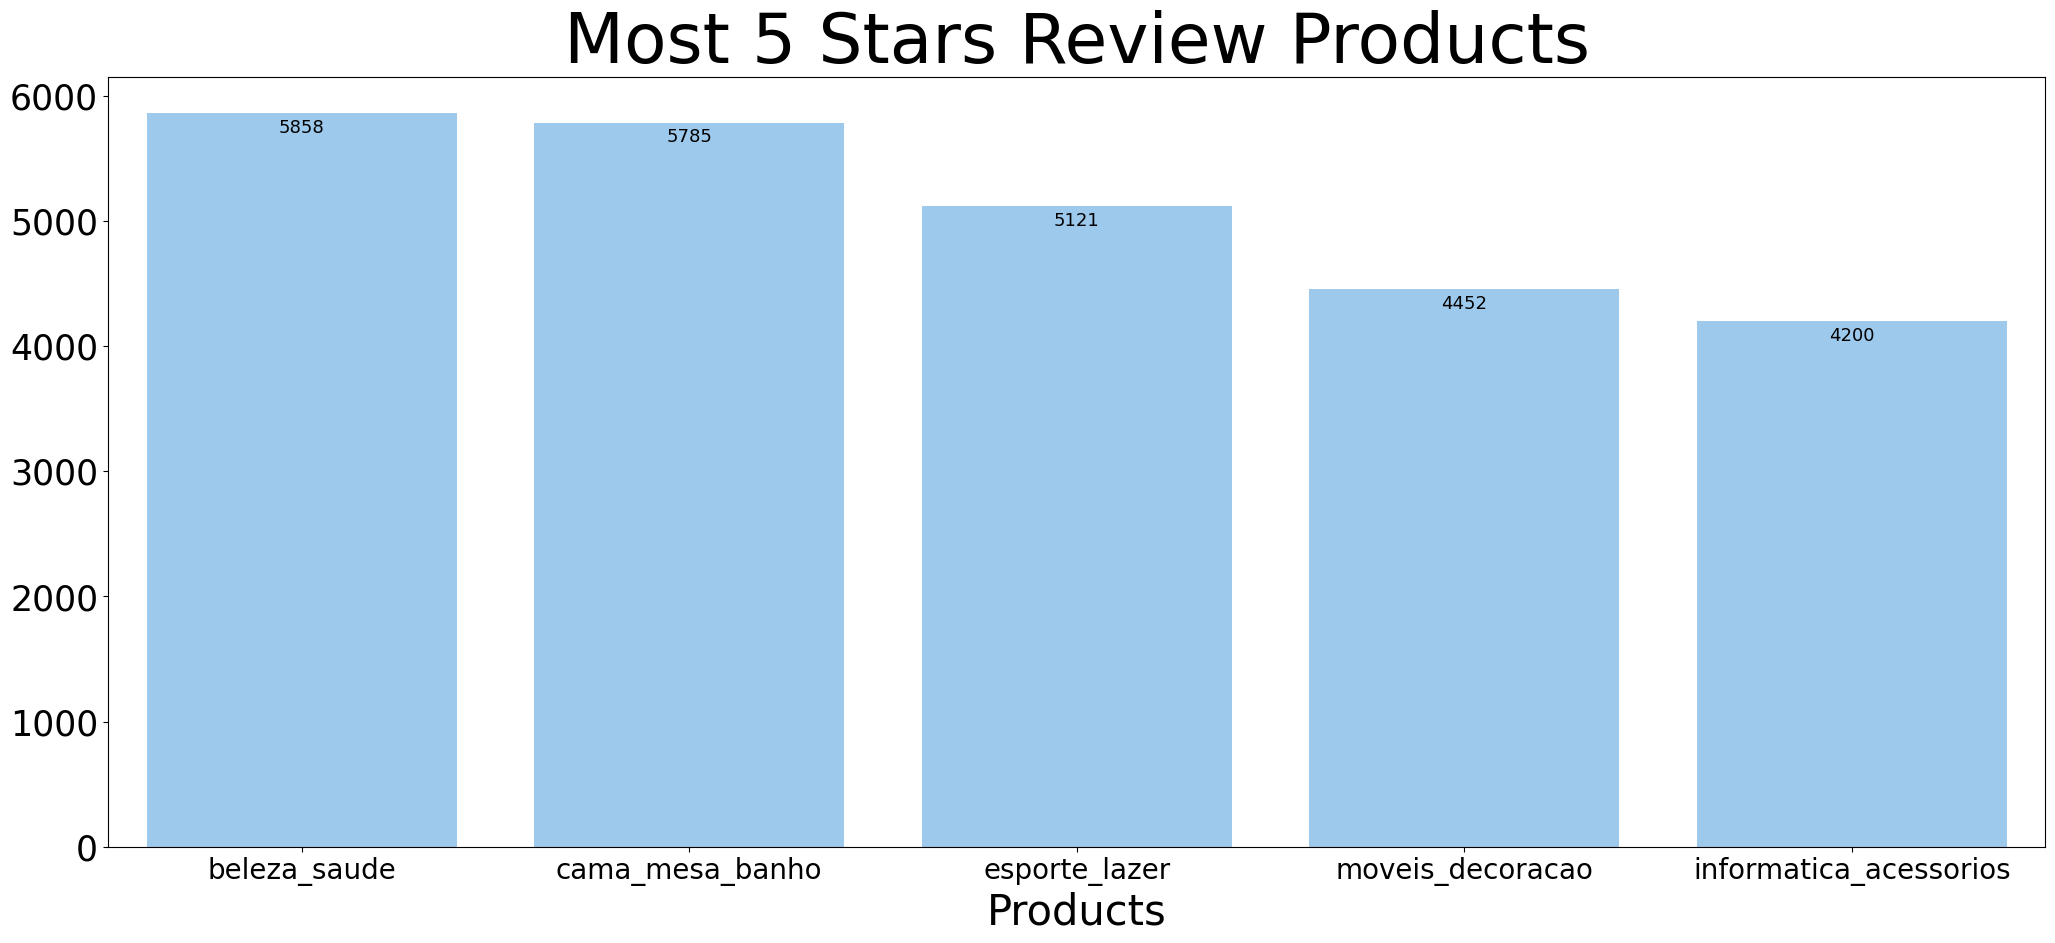

In [23]:
# Menggunakan dataframe product_review
topProduct_with_R5_df = product_with_R5_df.groupby(['product_category_name']).size().reset_index(name='count_5stars').sort_values('count_5stars', ascending=False)

colors_allblue = ["#90CAF9", "#90CAF9", "#90CAF9", "#90CAF9", "#90CAF9"]
fig, ax = plt.subplots(figsize=(25, 10))
sns.barplot(
    data=topProduct_with_R5_df.head(5),
    x='product_category_name',
    y='count_5stars',
    color='#90CAF9',
    ax=ax
    )
ax.set_title('Most 5 Stars Review Products', loc='center', fontsize=50)
ax.set_ylabel(None)
ax.set_xlabel('Products', fontsize=30)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=25)
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=13, padding=-17)
plt.show(fig)

### Pertanyaan 2: Seberapa besar faktor volume dan berat barang mempengaruhi harga pengiriman barang?

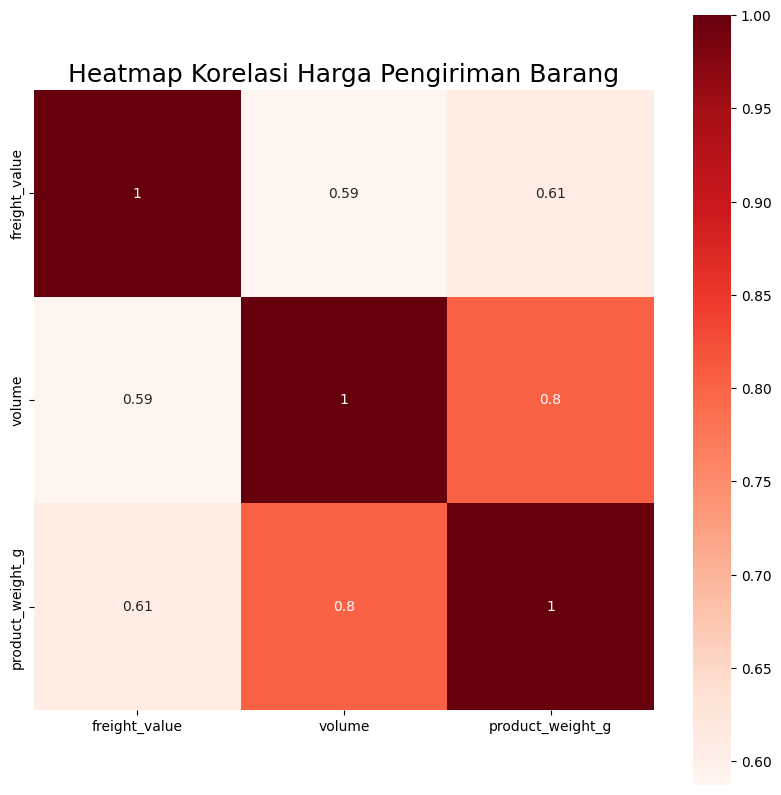

In [24]:
# Menggunakan dataframe freighValue_factor_df
corellation_data = freightValue_factor_df[['freight_value', 'volume', 'product_weight_g']]

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(
    data=corellation_data.corr(),
    annot=True,
    cmap='Reds',
    square=True,
    ax=ax)
ax.set_title('Heatmap Korelasi Harga Pengiriman Barang', loc='center', fontsize=18)
plt.show(fig)

### Pertanyaan 3 & Pertanyaan 4 akan divisualisasikan dengan analisis lanjutan pada Subpoint setelah ini

**Insight:**
- Barchart pertama meunjukan top 5 produk yang mendapatkan rating review bintang 5 dengan jumlah terbanyak

- Heatmap di atas menunjukan besaran korelasi / keberpengaruhan faktor berat dan volume product terhadap harga pengiriman barang

## Analisis Lanjutan (Opsional)

### Pertanyaan 3: Di mana letak geografis yang mempunyai angka pembelian tertinggi dan terendah? (Geospatial Analysis)

In [25]:
# Menggunakan dataframe geoloc_payment dengan menambahkan column geometry sebagai geospasial koordinat
geometry = [Point(xy) for xy in zip(geoloc_payment_df['geolocation_lng'], geoloc_payment_df['geolocation_lat'])]
geo_df = gpd.GeoDataFrame(data=geoloc_payment_df.sort_values(by='payment_value', ascending=True), geometry=geometry)
# Diurutkan dengan ascending=False agar visualisasi menunjukan data dengan payment value tertinggi berada di atas
geo_df.set_crs(epsg=4326, inplace=True)
#geo_df.crs = 4326

geo_df.head(20)

,customer_zip_code_prefix,geolocation_lat,geolocation_lng,payment_value,geolocation_city,geolocation_state,geometry
14578,95853,NaN,NaN,20.70,None,None,POINT (-46.63573 -23.54899)
8217,38819,-19.676989,-51.188937,25.51,rio paranaiba,MG,POINT (-46.63476 -23.5498)
3216,7430,NaN,NaN,28.62,None,None,POINT (-46.63673 -23.54946)
8178,38627,NaN,NaN,29.42,None,None,POINT (-46.63614 -23.5501)
6679,28340,-21.207949,-41.889774,31.69,boa ventura,RJ,POINT (-46.63725 -23.55005)
8320,39623,-19.893237,-43.986305,31.73,tuparece,MG,POINT (-46.63589 -23.546)
7801,36596,NaN,NaN,32.43,None,None,POINT (-46.63649 -23.54684)
11654,72899,-21.467829,-56.171869,34.09,jardim abc de goias,GO,POINT (-46.63558 -23.54691)
11884,74686,-16.556178,-49.244786,34.09,goiania,GO,POINT (-46.63486 -23.54779)
8663,43870,NaN,NaN,34.78,None,None,POINT (-46.63424 -23.54714)


<Axes: >

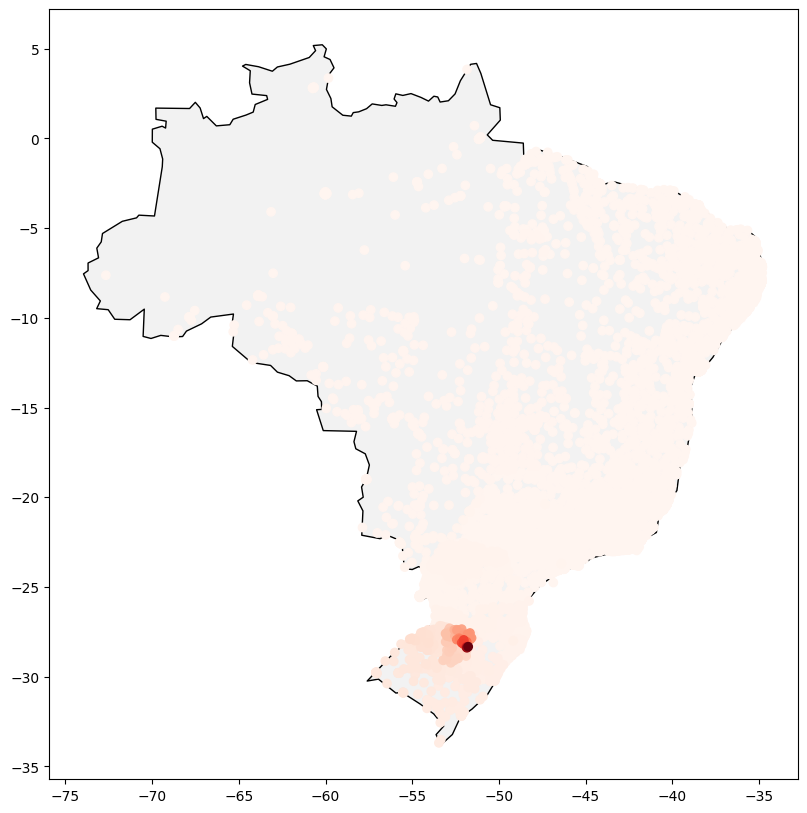

In [26]:
# Visualisasi Geospasial dengan Map Brazil yang menyesuaikan dengan isi data
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip")
brazil = world[world['NAME'] == 'Brazil']
brazil = brazil.to_crs(epsg=4326)
# brazil.crs = 4326


fig, ax = plt.subplots(figsize=(10, 10))
brazil.plot(figsize=(8, 8), color='#F2F2F2', edgecolor='black', ax=ax)
geo_df.plot(column='payment_value', ax=ax, cmap='Reds')




### Pertanyaan 4: Siapa sajakan pelanggan yang mempunyai performance paling tinggi dari sisi recency pembelian, frekuensi pembelian, dan total biaya belanja yang dikeluarkan? (RFM Analysis)

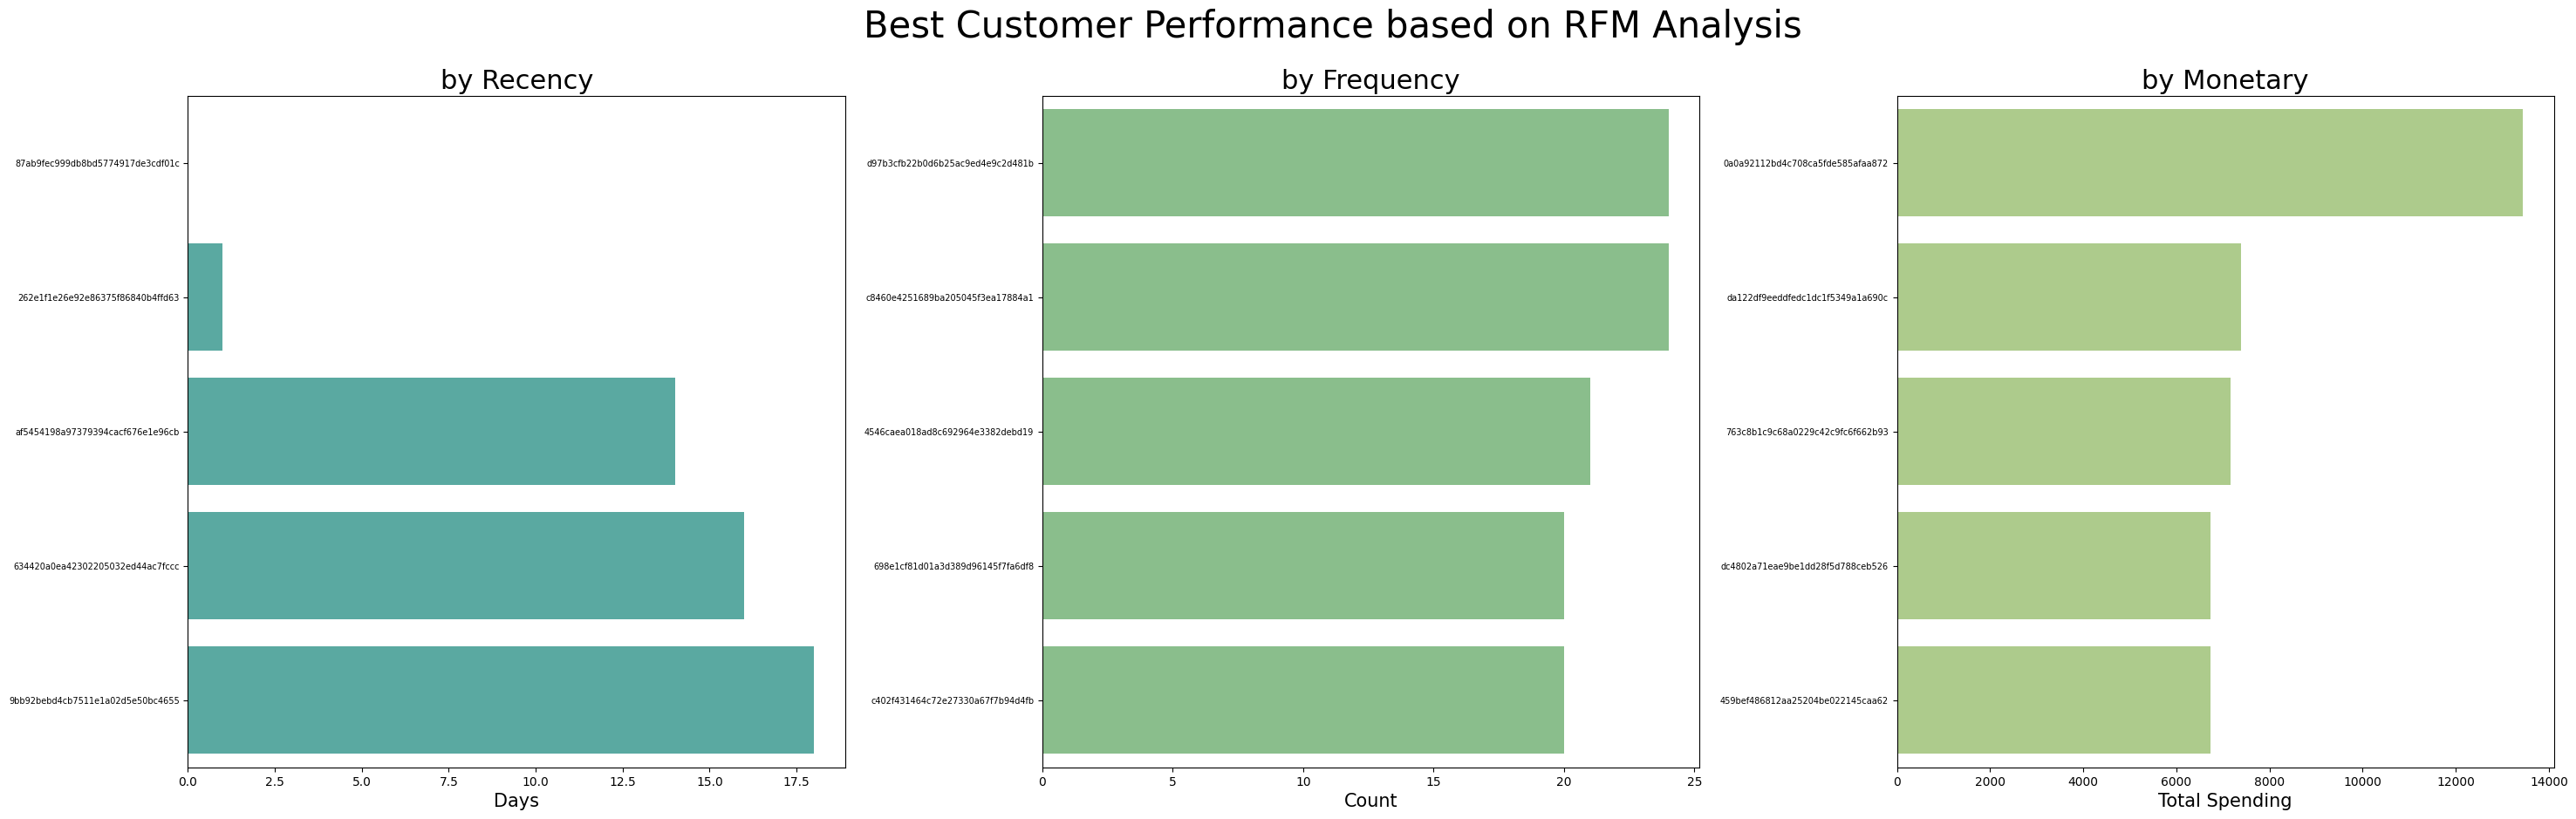

In [27]:
# Menggunakan dataframe RFM
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(35, 10))
plt.subplots_adjust(wspace=0.3)
fig.suptitle('Best Customer Performance based on RFM Analysis', fontsize=30)
sns.barplot(
    data=rfm_df.sort_values(by='recency', ascending=True).head(5),
    x='recency',
    y='customer_unique_id',
    color='#4DB6AC',
    ax=ax[0],
)
ax[0].set_title('by Recency', fontsize=22)
ax[0].set_xlabel('Days', fontsize=15)
ax[0].set_ylabel(None)
ax[0].tick_params(axis='x', labelsize=10)
ax[0].tick_params(axis='y', labelsize=7,)

sns.barplot(
    data=rfm_df.sort_values(by='frequency', ascending=False).head(5),
    x='frequency',
    y='customer_unique_id',
    color='#81C784',
    ax=ax[1],
)
ax[1].set_title('by Frequency', fontsize=22)
ax[1].set_xlabel('Count', fontsize=15)
ax[1].set_ylabel(None)
ax[1].tick_params(axis='x', labelsize=10)
ax[1].tick_params(axis='y', labelsize=7,)

sns.barplot(
    data=rfm_df.sort_values(by='monetary', ascending=False).head(5),
    x='monetary',
    y='customer_unique_id',
    color='#AED581',
    ax=ax[2],
)
ax[2].set_title('by Monetary', fontsize=22)
ax[2].set_xlabel('Total Spending', fontsize=15)
ax[2].set_ylabel(None)
ax[2].tick_params(axis='x', labelsize=10)
ax[2].tick_params(axis='y', labelsize=7,)

plt.show(fig)

Insight :
- Visualisasi geospatial di atas menjukan lokasi-lokasi customer dengan jumlah pembelian tertinggi
- Ketiga Barchart di atas menunjukan top 5 customer yang diukur dari performana RFM

## Conclusion

- Conclution pertanyaan 1 :
Ranking kategori dengan review bintang 5 terbanyak adalah beleza_saude, cama_mesa_banho, esporte_lazer, moveis_decoracao, informatica_acessorios.
Data ini dapat dijadikan pertimbangan untuk penerapan sistem promosi terhadap top produk dan peningkatan promo bagi produk yang belum ada.

- Conclution pertanyaan 2 : Keberpengaruhan volume dan berat hanya di tingkat agak kuat dan sedang dengan angka 0.587 & 0.610. Perlu dilakukan analisis lanjutan untuk mencari faktor pengaruh lainnya.

- Conclution pertanyaan 3 : Top 5 customer dari sisi RFM telah didapatkan. Data ini dapat digunakan sebagai sistem reward bagi top customer dengan performance terbaik.

- Conclution pertanyaan 4 : Didapatkan top location customer dari angka pembelian tertinggi di antaranya Niteroi, Rio De Janeiro, dan Divinopolis. Data ini dapat digunakan untuk program pengembangan gudang baru di daerah tersebut.


